# Transverse-field Ising Model Simulation

*Usage estimate: 2 minutes on ibm_kingston. (NOTE: This is an estimate only. Your runtime may vary.)*

## Background
The Transverse-Field Ising Model (TFIM) is important for studying quantum magnetism and phase transitions. It describes a set of spins arranged on a lattice, where each spin interacts with its neighbors while also being influenced by an external magnetic field that drives quantum fluctuations. 

Simulating this model on real hardware is challenging due to noise and decoherence. A common approach is to use Trotter decomposition to approximate the time evolution operator, constructing circuits that alternate between single-qubit rotations and entangling two-qubit interactions. In this tutorial we will:

* Build the TFIM Hamiltonian on a graph of connected spin triangles,
* Simulate time evolution with Trotterized circuits at different depths,
* Compute and visualize single-qubit magnetizations $\langle Z_i \rangle$ over time,
* Compare results from exact simulation and noisy hardware execution.


### Overview

The Transverse-field Ising Model (TFIM) is a quantum spin model that captures essential features of quantum phase transitions. The Hamiltonian is defined as:

$$
H = -J \sum_{i} Z_i Z_{i+1} - h \sum_{i} X_i
$$

where $Z_i$ and $X_i$ are Pauli operators acting on qubit $i$, $J$ is the coupling strength between neighboring spins, and $h$ is the strength of the transverse magnetic field. The first term represents classical ferromagnetic interactions, while the second introduces quantum fluctuations through the transverse field. To simulate TFIM dynamics, you use a **Trotter decomposition** of the unitary evolution operator $e^{-iHt}$, implemented through layers of RX and RZZ gates based on a custom graph of connected spin triangles. The simulation explores how magnetization $\langle Z \rangle$ evolves with increasing Trotter steps.

TFIM implementation performance is obtained by comparing **noiseless simulations** with **noisy backends**. Fire Opal’s enhanced execution and error suppression features are used to mitigate the effect of noise in real hardware, yielding more reliable estimates of spin observables like $\langle Z_i \rangle$ and correlators $\langle Z_i Z_j \rangle$.



## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.4 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime v0.40 or later (`pip install qiskit-ibm-runtime`)
- Qiskit Functions Catalog v0.9.0 (`pip install qiskit-ibm-catalog`)
- Fire Opal SDK v9.0.2 or later (`pip install fire-opal`)
- Q-CTRL Visualizer v8.0.2 or later (`pip install qctrl-visualizer`)


## Setup

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, qasm3
from qiskit_ibm_catalog import QiskitFunctionsCatalog
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

import qctrlvisualizer as qv

import pickle
import numpy as np
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Set credentials.
token = "YOUR_IBM_CLOUD_API_KEY"
instance = "YOUR_IBM_CRN"

catalog = QiskitFunctionsCatalog(
    channel="ibm_quantum_platform", instance=instance, token=token
)

# Access Function
perf_mgmt = catalog.load("q-ctrl/performance-management")

## Step 1: Generate TFIM Graph
We begin by defining the lattice of spins and the couplings between them. In this tutorial, the lattice is constructed from connected triangles arranged in a linear chain. Each triangle consists of three nodes connected in a closed loop, and the chain is formed by linking one node of each triangle to the previous triangle.

The helper function `connected_triangles_adj_matrix` builds the adjacency matrix for this structure. For a chain of $n$ triangles, the resulting graph contains $2n+1$ nodes.

In [ ]:
def connected_triangles_adj_matrix(n):
    """
    Generate the adjacency matrix for 'n' connected triangles in a chain.
    """
    num_nodes = 2 * n + 1
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(n):
        a, b, c = i * 2, i * 2 + 1, i * 2 + 2  # Nodes of the current triangle

        # Connect the three nodes in a triangle
        adj_matrix[a, b] = adj_matrix[b, a] = 1
        adj_matrix[b, c] = adj_matrix[c, b] = 1
        adj_matrix[a, c] = adj_matrix[c, a] = 1

        # If not the first triangle, connect to the previous triangle
        if i > 0:
            adj_matrix[a, a - 1] = adj_matrix[a - 1, a] = 1

    return adj_matrix

To visualize the lattice we just defined, we can plot the chain of connected triangles and label each node. The function below builds the graph for a chosen number of triangles and displays it.

In [ ]:
def plot_triangle_chain(n, side=1.0):
    """
    Plot a horizontal chain of n equilateral triangles.
    Baseline: even nodes (0,2,4,...,2n) on y=0
    Apexes: odd nodes (1,3,5,...,2n-1) above the midpoint.
    """
    # Build graph
    A = connected_triangles_adj_matrix(n)
    G = nx.from_numpy_array(A)

    h = np.sqrt(3) / 2 * side
    pos = {}

    # Place baseline nodes
    for k in range(n + 1):
        pos[2 * k] = (k * side, 0.0)

    # Place apex nodes
    for k in range(n):
        x_left = pos[2 * k][0]
        x_right = pos[2 * k + 2][0]
        pos[2 * k + 1] = ((x_left + x_right) / 2, h)

    # Draw
    fig, ax = plt.subplots(figsize=(1.5 * n, 2.5))
    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=True,
        font_size=10,
        font_color="white",
        node_size=600,
        node_color=qv.QCTRL_STYLE_COLORS[0],
        edge_color="black",
        width=2,
    )
    ax.set_aspect("equal")
    ax.margins(0.2)
    plt.show()

    return G, pos

For this tutorial we will use a chain of 17 triangles

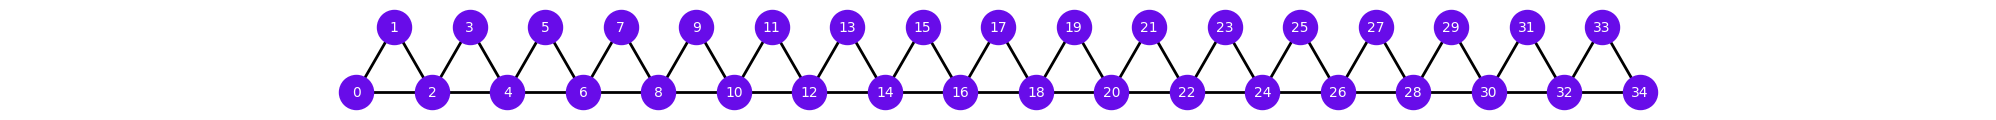

In [ ]:
n_triangles = 17  # 17
n_qubits = 2 * n_triangles + 1
plot_triangle_chain(n_triangles, side=1.0)
plt.show()

## Step 2: Coloring Graph Edges
To implement the spin–spin coupling, it is useful to group edges that do not overlap. This allows us to apply two-qubit gates in parallel. We can do this with a simple edge-coloring procedure [\[1\]](#references), which assigns a color to each edge so that edges meeting at the same node are placed in different groups.

In [ ]:
def edge_coloring(graph):
    """
    Takes a NetworkX graph and returns a list of lists where each inner list contains
    the edges assigned the same color.
    """
    line_graph = nx.line_graph(graph)
    edge_colors = nx.coloring.greedy_color(line_graph)

    color_groups = {}
    for edge, color in edge_colors.items():
        if color not in color_groups:
            color_groups[color] = []
        color_groups[color].append(edge)

    return list(color_groups.values())

## Step 3: Generate Trotterized circuits on spin graphs

To simulate the dynamics of the Transverse-Field Ising Model, we construct circuits that approximate the time evolution operator

$$
U(t) = e^{-i H t}, \quad \text{where} \quad H = -J \sum_{\langle i,j \rangle} Z_i Z_j - h \sum_i X_i .
$$

We use a second-order Trotter decomposition:

$$
e^{-i H \Delta t} \approx e^{-i H_X \Delta t / 2}\, e^{-i H_Z \Delta t}\, e^{-i H_X \Delta t / 2},
$$

where $H_X = -h \sum_i X_i$ and $H_Z = -J \sum_{\langle i,j \rangle} Z_i Z_j$.

* The $H_X$ term is implemented with layers of `RX` rotations.
* The $H_Z$ term is implemented with layers of `RZZ` gates along the edges of the interaction graph.

The angles of these gates are determined by the transverse field $h$, the coupling constant $J$, and the time step $\Delta t$. By stacking multiple Trotter steps, we generate circuits of increasing depth that approximate the system’s dynamics. The functions `generate_tfim_circ_custom_graph` and `trotter_circuits` construct a Trotterized quantum circuit from an arbitrary spin interaction graph.

In [ ]:
def generate_tfim_circ_custom_graph(
    steps, h, J, dt, psi0, graph: nx.graph.Graph, meas_basis="Z", mirror=False
):
    """
    Generate a second order trotter of the form e^(a+b) ~ e^(b/2) e^a e^(b/2) for simulating a transverse field ising model:
    e^{-i H t} where the Hamiltonian H = -J \\sum_i Z_i Z_{i+1} + h \\sum_i X_i.

    steps: Number of trotter steps
    theta_x: Angle for layer of X rotations
    theta_zz: Angle for layer of ZZ rotations
    theta_x: Angle for second layer of X rotations
    J: Coupling between nearest neighbouring spins
    h: The transverse magnetic field strength
    dt: t/total_steps
    psi0: initial state (assumed to be prepared in the computational basis).
    meas_basis: basis to meaasure all correlators in

    This is a second order trotter of the form e^(a+b) ~ e^(b/2) e^a e^(b/2)
    """
    theta_x = h * dt
    theta_zz = -2 * J * dt
    nq = graph.number_of_nodes()
    color_edges = edge_coloring(graph)
    circ = QuantumCircuit(nq, nq)
    # Initial state, for typical cases in the computational basis
    for i, b in enumerate(psi0):
        if b == "1":
            circ.x(i)
    # Trotter steps
    for step in range(steps):
        for i in range(nq):
            circ.rx(theta_x, i)
        if mirror:
            color_edges = [sublist[::-1] for sublist in color_edges[::-1]]
        for edge_list in color_edges:
            for edge in edge_list:
                circ.rzz(theta_zz, edge[0], edge[1])
        for i in range(nq):
            circ.rx(theta_x, i)

    # some typically used basis rotations
    if meas_basis == "X":
        for b in range(nq):
            circ.h(b)
    elif meas_basis == "Y":
        for b in range(nq):
            circ.sdg(b)
            circ.h(b)

    for i in range(nq):
        circ.measure(i, i)

    return circ


def trotter_circuits(G, d_ind_tot, J, h, dt, meas_basis, mirror=True):
    """
    Generates a sequence of Trotterized circuits, each with increasing depth.
    Given a spin interaction graph and Hamiltonian parameters, it constructs
    a list of circuits with 1 to d_ind_tot Trotter steps

    G: Graph defining spin interactions (edges = ZZ couplings)
    d_ind_tot: Number of Trotter steps (maximum depth)
    J: Coupling between nearest neighboring spins
    h: Transverse magnetic field strength
    dt: (t / total_steps
    meas_basis: Basis to measure all correlators in
    mirror: If True, mirror the Trotter layers
    """
    qubit_count = len(G)
    circuits = []
    psi0 = "0" * qubit_count

    for steps in range(1, d_ind_tot + 1):
        circuits.append(
            generate_tfim_circ_custom_graph(
                steps, h, J, dt, psi0, G, meas_basis, mirror
            )
        )
    return circuits

## Step 4: Estimate Single-Qubit Magnetizations $\langle Z_i \rangle$
To study the dynamics of the model, we want to measure the magnetization of each qubit, defined by the expectation value $\langle Z_i \rangle = \langle \psi | Z_i | \psi \rangle$

In simulations, we can compute this directly from the measurement outcomes. The function `z_expectation` processes the bitstring counts and returns the value of $\langle Z_i \rangle$ for a chosen qubit index. On real hardware, we evaluate the same quantity by specifying the Pauli operator using the function `generate_z_observables` and letting the backend compute the expectation value. 


In [ ]:
def z_expectation(counts, index):
    """
    counts: Dict of mitigated bitstrings.
    index: Index i in the single operator expectation value < II...Z_i...I > to be calculated.
    return:  < Z_i >
    """
    z_exp = 0
    tot = 0
    for bitstring, value in counts.items():
        bit = int(bitstring[index])
        sign = 1
        if bit % 2 == 1:
            sign = -1
        z_exp += sign * value
        tot += value

    return z_exp / tot

In [ ]:
def generate_z_observables(nq):
    observables = []
    for i in range(nq):
        pauli_string = "".join(["Z" if j == i else "I" for j in range(nq)])
        observables.append(SparsePauliOp(pauli_string))
    return observables

In [ ]:
observables = generate_z_observables(n_qubits)
observables

## Step 5: Execute the Algorithm
We now define the parameters for generating the Trotterized circuits. In this tutorial, the lattice is a chain of 17 connected triangles, which corresponds to a 35-qubit system.

In [ ]:
all_circs_mirror = []
for num_triangles in [n_triangles]:
    for meas_basis in ["Z"]:
        A = connected_triangles_adj_matrix(num_triangles)
        G = nx.from_numpy_array(A)
        nq = len(G)
        d_ind_tot = 21
        dt = 2 * np.pi * 1 / 30 * 0.5
        J = 1
        h = -4
        all_circs_mirror.extend(
            trotter_circuits(G, d_ind_tot, J, h, dt, meas_basis, True)
        )
circs = all_circs_mirror

### Run exact simulation
The list of Trotterized circuits is executed using the `matrix_product_state` simulator with $4096$ shots. The raw counts are normalized, and from these we compute the single-qubit expectation values $\langle Z_i \rangle$ at each Trotter step. Finally, we calculate the average over all qubits to obtain a single curve that shows how the magnetization changes over time.

In [ ]:
backend_sim = AerSimulator(method="matrix_product_state")


def normalize_counts(counts_list, shots):
    new_counts_list = []
    for counts in counts_list:
        a = {k: v / shots for k, v in counts.items()}
        new_counts_list.append(a)
    return new_counts_list


def run_sim(circ_list):
    shots = 4096
    res = backend_sim.run(circ_list, shots=shots)
    normed = normalize_counts(res.result().get_counts(), shots)
    return normed


sim_counts = run_sim(circs)

In [ ]:
def make_correlators(test_counts, nq, d_ind_tot):
    """
    d_ind_tot : max_depth
    """
    mz = np.empty((nq, d_ind_tot))  # <Z_i>
    # zzij = np.empty((nq, nq, d_ind_tot)) # <Z_i Z_j>

    for d_ind in range(d_ind_tot):
        counts = test_counts[d_ind]
        for i in range(nq):
            mz[i, d_ind] = z_expectation(counts, i)
    return mz


def make_cors(counts, nq):
    d_ind_tot = 21
    mz = make_correlators(counts, nq, d_ind_tot=d_ind_tot)
    average_z = np.mean(mz, axis=0)
    return np.concatenate((np.array([1]), average_z), axis=0)


sim_exp = make_cors(sim_counts[0:21], nq=nq)

### Run on hardware
We evaluate the magnetization dynamics on real quantum hardware. Fire Opal provides a Qiskit function that extends the standard Qiskit Runtime Estimator primitive with automated error suppression and performance management. This allows us to submit the Trotterized circuits directly to an IBM backend while letting Fire Opal handle noise-aware execution.

We prepare a list of `pubs`, where each item contains a circuit and the corresponding Pauli-Z observables. These are passed to Fire Opal’s estimator function, which returns the expectation values $\langle Z_i \rangle$ for each qubit at each Trotter step. The results can then be averaged over qubits to obtain the magnetization curve from hardware.

In [ ]:
backend_name = "ibm_kingston"
estimator_pubs = [(qasm3.dumps(qc), observables) for qc in all_circs_mirror[:]]

# Run the circuit using the estimator
qctrl_estimator_job = perf_mgmt.run(
    primitive="estimator",
    pubs=estimator_pubs,
    backend_name=backend_name,
    options={"default_shots": 16384},
)

In [ ]:
qctrl_estimator_job.status()

'DONE'

In [ ]:
result = qctrl_estimator_job.result()

In [ ]:
real_exp = [ev.data.evs for ev in result[:]]
real_exp_mean = np.concatenate((np.array([1]), np.mean(real_exp, axis=1)), axis=0)

## Step 6: Plot results
Finally, we compare the magnetization curve from the simulator with the results obtained on real hardware. Plotting both side by side shows how closely the hardware execution with Fire Opal matches the noiseless baseline across Trotter steps.

In [ ]:
def make_expectations_plot(exp_z, exp_z_error, sim_z, depths, name):

    plot_upto = 21
    plot_from = 0
    depth_ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

    # depth_ticks = [10, 12, 14, 16, 18, 20]
    sim_z = sim_z
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    top = np.max(sim_z[plot_from:plot_upto])
    bottom = np.min(sim_z[plot_from:plot_upto])
    top = 1.05
    bottom = -1.05

    ax.plot(
        depths[plot_from:plot_upto],
        sim_z[plot_from:plot_upto],
        color="grey",
        label="Noiseless simulation",
    )
    # ax.hlines([0], 10, 20, color="black", linestyles='dashed', label = "The random limit")

    if name == "qctrl":
        ax.errorbar(
            depths[plot_from:plot_upto],
            exp_z[plot_from:plot_upto],
            yerr=exp_z_error[plot_from:plot_upto],
            fmt="o",
            markersize=7,
            color="#680CE9",
            label="Fire Opal",
            alpha=0.7,
            capsize=4,
            capthick=1,
        )
    elif name == "estimator":
        ax.errorbar(
            depths[plot_from:plot_upto],
            exp_z[plot_from:plot_upto],
            yerr=exp_z_error[plot_from:plot_upto],
            fmt="o",
            markersize=7,
            color="black",
            label="Default QiskitRuntime",
            alpha=0.7,
            capsize=4,
            capthick=1,
        )

    ax.set_ylabel(r"$\langle Z \rangle$")
    ax.set_xticks(depth_ticks)
    ax.set_xlabel("Trotter step")
    ax.legend()

    ax.set_ylim(bottom, top)
    ax.legend(prop={"size": 8})

    # fig.suptitle(f'Nq = {nq}')
    plt.tight_layout()
    plt.show()

In [ ]:
depths = list(range(d_ind_tot + 1))
errors = np.abs(np.array(real_exp_mean[:-3]) - np.array(sim_exp[:-3]))

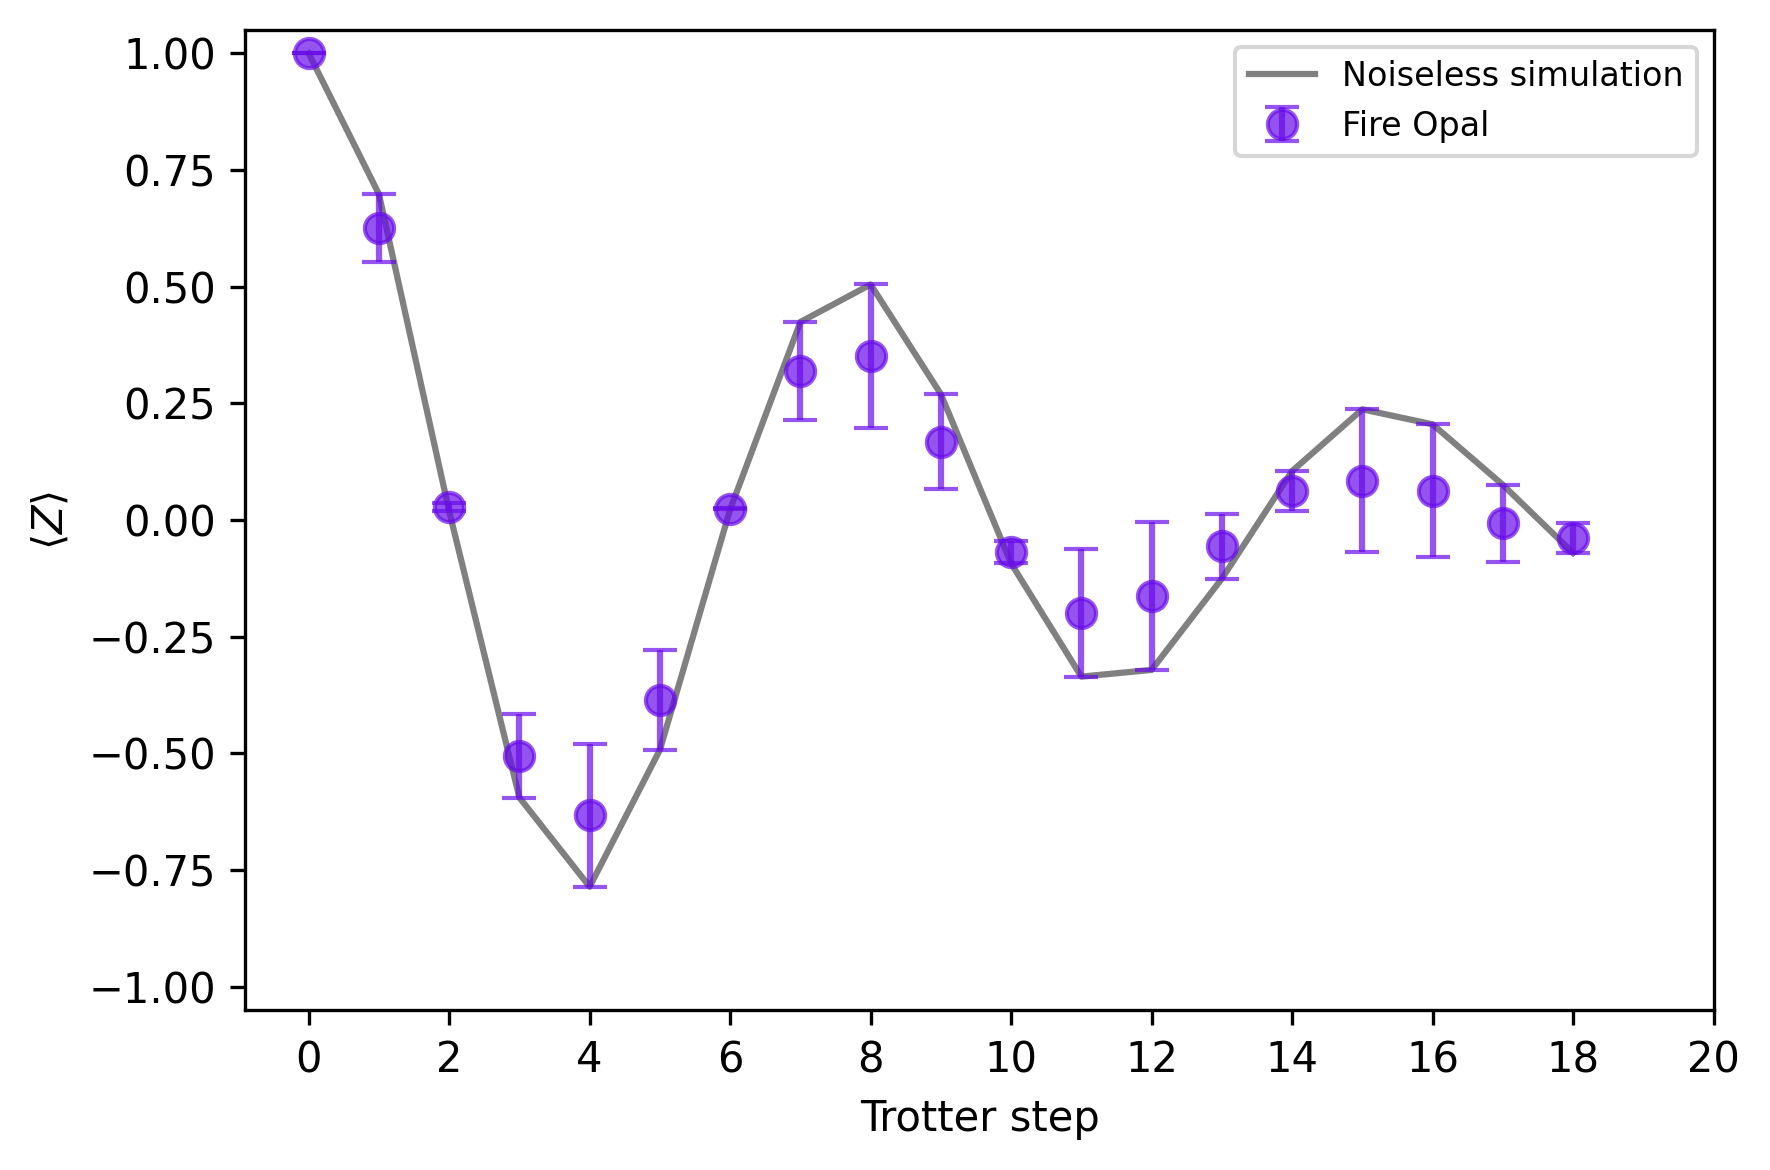

In [ ]:
make_expectations_plot(real_exp_mean[:-3], errors, sim_exp[:-3], depths[:-3], "qctrl")

## References
[\[1\]](#Reference1) Graph coloring. In Wikipedia. Retrieved September 15, 2025, from https://en.wikipedia.org/wiki/Graph_coloring

## Tutorial survey

Please take a minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_3BLFkNVEuh0QBWm)